# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os
import cv2
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

# import visualkeras
from PIL import ImageFont


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Spliting out Data into Train and Test Directories with a 30% Split

In [3]:
# # Creating a dictonary for each folder name and value
# val_dic = {'VeryMildDemented':2688, 'ModerateDemented':1939, 'MildDemented':2688, 'NonDemented':2880}x

In [4]:
# Train_Test_test = '/content/drive/MyDrive/Flatiron/Phase 5/Train:Test/Test'

In [5]:
# # making a copy of the each images from Data directory to Test directory
# for val, key in val_dic.items():
#     origin = f'{path}/{val}/'
#     test = f'{Train_Test_test }/{val}/'

#     files = os.listdir(origin)[:key]


#     # Fetching all the files to directory
#     for file_name in files:
#         shutil.copy(origin+file_name, test+file_name)

In [6]:
# # Checking the Length of the Test Directory
# print(len(os.listdir(f'{Train_Test_test}/VeryMildDemented/')))
# print(len(os.listdir(f'{Train_Test_test}/ModerateDemented/')))
# print(len(os.listdir(f'{Train_Test_test}/MildDemented/')))
# print(len(os.listdir(f'{Train_Test_test}/NonDemented/')))

In [7]:
# Train_Test_train = '/content/drive/MyDrive/Flatiron/Phase 5/Train:Test/Train'

In [8]:
# # making a copy of the each images from Data directory to Train directory
# for val, key in val_dic.items():
#     origin = f'{path}/{val}/'
#     train = f'{Train_Test_train}/{val}/'

#     files = os.listdir(origin)[key:]

#     # Fetching all the files to directory
#     for file_name in files:
#         shutil.copy(origin+file_name, train+file_name)

In [9]:
# # Checking the Length of the Train Directory
# print(len(os.listdir(f'{Train_Test_train}/VeryMildDemented/')))
# print(len(os.listdir(f'{Train_Test_train}/ModerateDemented/')))
# print(len(os.listdir(f'{Train_Test_train}/MildDemented/')))
# print(len(os.listdir(f'{Train_Test_train}/NonDemented/')))

# Taking Folder from Google Drive to Google Colab Local Notebook

In [11]:

# Origial folder location
test_scr_dir = '/content/drive/MyDrive/Flatiron/Phase 5/Train:Test/Test'
train_scr_dir= '/content/drive/MyDrive/Flatiron/Phase 5/Train:Test/Train'


# Google Colab Local Stoarage
test_dst_folder = '/content/test'
train_dst_folder = '/content/train'


# copy folder from location to local storage

shutil.copytree(test_scr_dir, test_dst_folder)
shutil.copytree(train_scr_dir, train_dst_folder)

'/content/train'

# Loading with ImageDataGenerator

In [12]:
# Path to the directory containing the training images
train_dir = '/content/train'
test_dir = '/content/test'
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']
['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [13]:
image_size = (150, 150)
# Image dimensions

In [14]:
# Creating an instance of the ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Rescale pixel values between 0 and 1
#     horizontal_flip=True,     # Randomly flip images horizontally
#     rotation_range=20,         # Randomly rotate images by 20 degrees
#     vertical_flip=True,        # Randomly flip images vertically
#     Flips and rotations dont really help
    validation_split=0.2       # Split 20% of data for validation
)


# Creating an instance of the ImageDataGenerator for the Testing
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Rescale pixel values between 0 and 1
)

In [15]:
# Generating training data from the images in the specified directory
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'# Use subset 'training' for training data
)

Found 19040 images belonging to 4 classes.


In [16]:
# Generating validation data from the images in the specified directory
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # Use subset 'validation' for validation data
)

Found 4758 images belonging to 4 classes.


In [17]:
# Generating Testing data from the images in the specified directory
testing_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
     shuffle = False
)

Found 10195 images belonging to 4 classes.


# Inception Model

In [18]:
# import inception model
from keras.applications import InceptionV3

In [19]:
inception = InceptionV3(
    include_top=False, # Do not include the fully connected layers at the top of the network
    weights='imagenet', # Load weights pre-trained on ImageNet
    input_shape=(150, 150, 3) # Image size
)


# making all the layers non-trainable
for layer in inception.layers:
  layer.trainable = False


87910968/87910968 [==============================] - 4s 0us/step


# Adding to the Inception Model

In [20]:
reg = L2(3e-3) # 1e-5 to .1

In [21]:
# Flatten the output layer to 1 dimension with Gobal average pooling

x  = GlobalAveragePooling2D()(inception.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(64, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inception.input, outputs=x)

# Optimizer and Summary

In [22]:
opt = Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999 ) # typical parameters

In [23]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy','AUC'] )

In [24]:
# model.summary()

# Fit the Model

In [25]:
#  will use validation loss: stopping to prevent overfitting.
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-6, patience = 5)

In [26]:
# Training the model
history_model = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=[trainCallback]
)

Epoch 1/35
595/595 [==============================] - 1181s 2s/step - loss: 0.9715 - accuracy: 0.5671 - auc: 0.8283 - val_loss: 0.8065 - val_accuracy: 0.6454 - val_auc: 0.8828
Epoch 2/35
595/595 [==============================] - 1169s 2s/step - loss: 0.7880 - accuracy: 0.6517 - auc: 0.8873 - val_loss: 0.7541 - val_accuracy: 0.6604 - val_auc: 0.8958
Epoch 3/35
595/595 [==============================] - 1169s 2s/step - loss: 0.7323 - accuracy: 0.6744 - auc: 0.9024 - val_loss: 0.7443 - val_accuracy: 0.6633 - val_auc: 0.8982
Epoch 4/35
595/595 [==============================] - 1132s 2s/step - loss: 0.6912 - accuracy: 0.6935 - auc: 0.9134 - val_loss: 0.7169 - val_accuracy: 0.6795 - val_auc: 0.9062
Epoch 5/35
595/595 [==============================] - 1167s 2s/step - loss: 0.6723 - accuracy: 0.7077 - auc: 0.9178 - val_loss: 0.6943 - val_accuracy: 0.6978 - val_auc: 0.9133
Epoch 6/35
595/595 [==============================] - 1171s 2s/step - loss: 0.6549 - accuracy: 0.7110 - auc: 0.9222 - va

# Evaluate Model

In [27]:
# Model evaluation
model.evaluate(testing_generator)

319/319 [==============================] - 494s 2s/step - loss: 0.6312 - accuracy: 0.7588 - auc: 0.9388


[0.6312129497528076, 0.7588033080101013, 0.9388198852539062]

In [ ]:
# Model prediction
y_true = testing_generator.classes
y_pred_probs = model.predict(testing_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

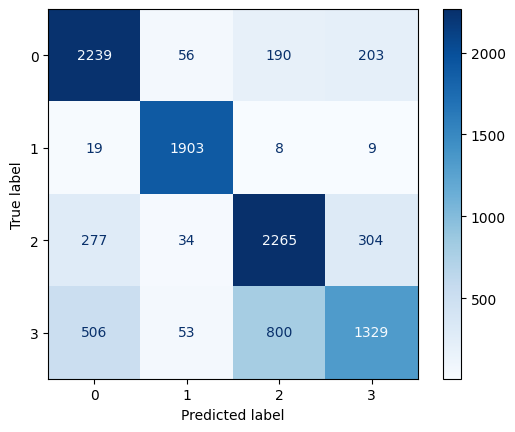

In [29]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
train_history_model = pd.DataFrame(history_model.history)
train_history_model.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_history_model[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

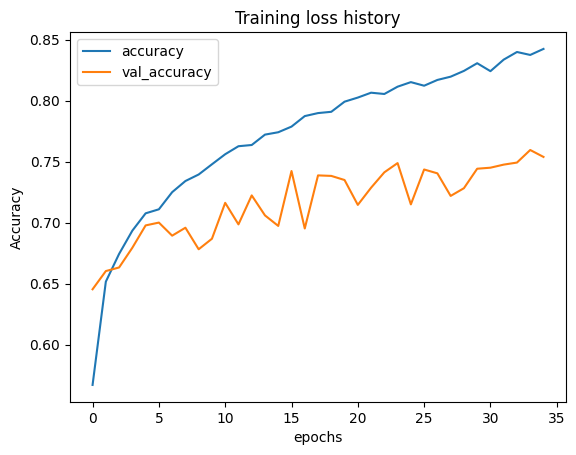

In [31]:
col_list = ['accuracy', 'val_accuracy']
train_history_model[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

# Visualize the Model Architecture

In [33]:
# pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 9.5 MB/s eta 0:00:00


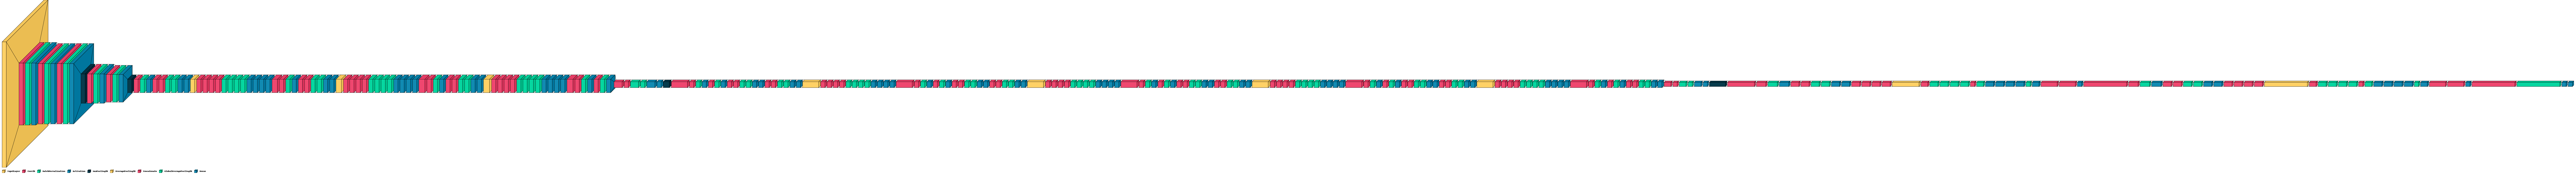

In [34]:
import visualkeras
visualkeras.layered_view(model, legend=True)